# Combine error mitigation options with the Estimator primitive
*Usage estimate: 8 minutes on ibm_fez (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

In this tutorial, you'll explore the error suppression and error mitigation options available with the Estimator primitive from Qiskit Runtime. You will construct a circuit and observable and submit jobs using the Estimator primitive using different combinations of error mitigation settings. Then, you will plot the results to observe the effects of the various settings. Most of the tutorial uses a 10-qubit circuit to make visualizations easier, and at the end, you can scale up the workflow to 50 qubits.

These are the error suppression and mitigation options you will use:

- Dynamical decoupling
- Measurement error mitigation
- Gate twirling
- Zero-noise extrapolation (ZNE)

## Requirements

Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK 1.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit.library import EfficientSU2, UnitaryOverlap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

## Step 1: Map classical inputs to a quantum problem

This tutorial assumes that the classical problem has already been mapped to quantum. Begin by constructing a circuit and observable to measure. While the techniques used in this tutorial apply to many different kinds of circuits, for simplicity this tutorial uses the [`EfficientSU2`](/docs/api/qiskit/qiskit.circuit.library.EfficientSU2#efficientsu2) circuit included in Qiskit's circuit library.

`EfficientSU2` is a parameterized quantum circuit designed to be efficiently executable on quantum hardware with limited qubit connectivity, while still being expressive enough to solve problems in application domains like optimization and chemistry. It's built by alternating layers of parameterized single-qubit gates with a layer containing a fixed pattern of two-qubit gates, for a chosen number of repetitions. The pattern of two-qubit gates can be specified by the user. Here you can use the built-in `pairwise` pattern because it minimizes the circuit depth by packing the two-qubit gates as densely as possible. This pattern can be executed using only linear qubit connectivity.

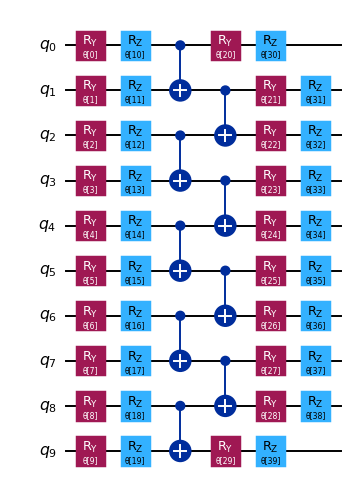

In [2]:
n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

For our observable, let's take the Pauli $Z$ operator acting on the last qubit, $Z I \cdots I$.

In [3]:
# Z on the last qubit (index -1) with coefficient 1.0
observable = SparsePauliOp.from_sparse_list(
    [("Z", [-1], 1.0)], num_qubits=n_qubits
)

At this point, you could proceed to run your circuit and measure the observable. However, you also want to compare the output of the quantum device with the correct answer - that is, the theoretical value of the observable, if the circuit had been executed without error. For small quantum circuits you can calculate this value by simulating the circuit on a classical computer, but this is not possible for larger, utility-scale circuits. You can work around this issue with the "mirror circuit" technique (also known as "compute-uncompute"), which is useful for benchmarking the performance of quantum devices.

#### Mirror circuit

In the mirror circuit technique, you concatenate the circuit with its inverse circuit, which is formed by inverting each gate of the circuit in reverse order. The resulting circuit implements the identity operator, which can trivially be simulated. Because the structure of the original circuit is preserved in the mirror circuit, executing the mirror circuit still gives an idea of how the quantum device would perform on the original circuit.

The following code cell assigns random parameters to your circuit, and then constructs the mirror circuit using the [`UnitaryOverlap`](/docs/api/qiskit/qiskit.circuit.library.UnitaryOverlap#unitaryoverlap) class. Before mirroring the circuit, append a [barrier](/docs/api/qiskit/circuit#qiskit.circuit.Barrier) instruction to it to prevent the transpiler from merging the two parts of the circuit on either side of the barrier. Without the barrier, the transpiler would merge the original circuit with its inverse, resulting in a transpiled circuit without any gates.

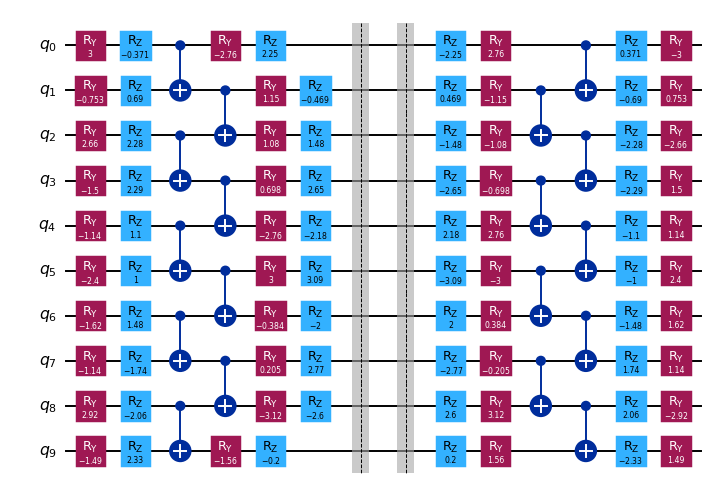

In [4]:
# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

## Step 2: Optimize problem for quantum hardware execution

You must optimize your circuit before running it on hardware. This process involves a few steps:

- Pick a qubit layout that maps the virtual qubits of your circuit to physical qubits on the hardware.
- Insert swap gates as needed to route interactions between qubits that are not connected.
- Translate the gates in your circuit to [Instruction Set Architecture (ISA)](/docs/guides/transpile#instruction-set-architecture) instructions that can directly be executed on the hardware.
- Perform circuit optimizations to minimize the circuit depth and gate count.

The transpiler built into Qiskit can perform all of these steps for you. Because this tutorial uses a hardware-efficient circuit, the transpiler should be able to pick a qubit layout that does not require any swap gates to be inserted for routing interactions.

You need to choose the hardware device to use before you optimize your circuit. The following code cell requests the least busy device with at least 127 qubits.

In [6]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
backend

<IBMBackend('ibm_fez')>

You can transpile your circuit for your chosen backend by creating a pass manager and then running the pass manager on the circuit. An easy way to create a pass manager is to use the [`generate_preset_pass_manager`](/docs/api/qiskit/qiskit.transpiler.generate_preset_pass_manager) function. See [Transpile with pass managers](/docs/guides/transpile-with-pass-managers) for a more detailed explanation of transpiling with pass managers.

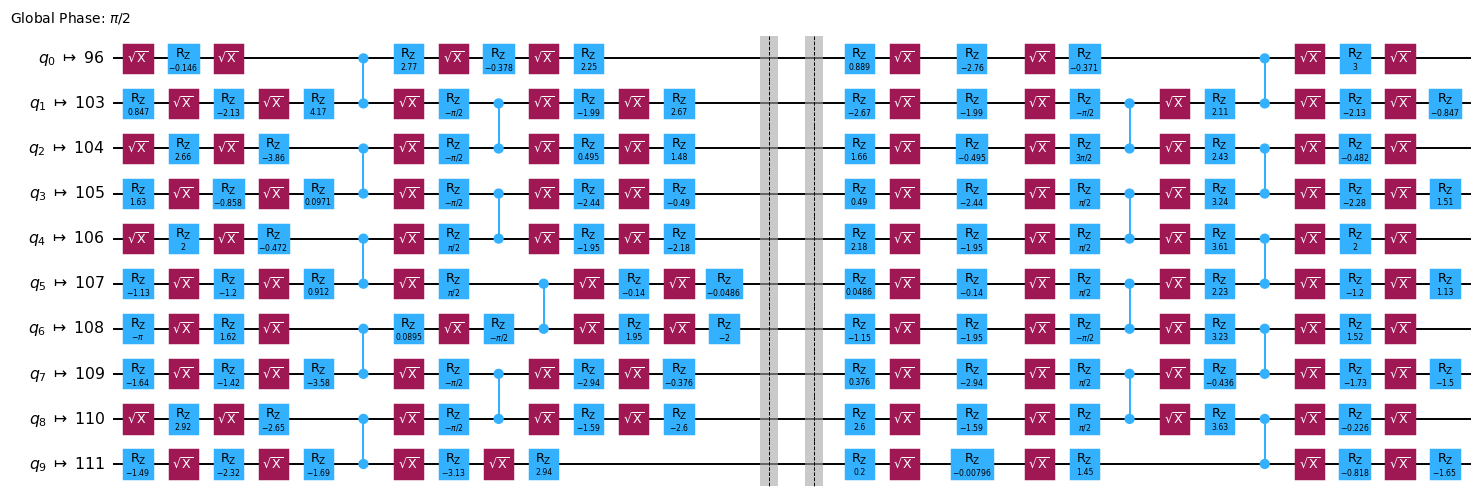

In [7]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

The transpiled circuit now contains only ISA instructions. The single-qubit gates have been decomposed in terms of $\sqrt{X}$ gates and $R_z$ rotations, and the CX gates have been decomposed into [ECR gates](/docs/api/qiskit/qiskit.circuit.library.ECRGate#ecrgate) and single-qubit rotations.

The transpilation process has mapped the virtual qubits of the circuit to physical qubits on the hardware. The information about the qubit layout is stored in the `layout` attribute of the transpiled circuit. The observable was also defined in terms of the virtual qubits, so you need to apply this layout to the observable, which you can do with the [`apply_layout`](/docs/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) method of `SparsePauliOp`.

In [8]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


## Step 3: Execute using Qiskit primitives

You are now ready to run your circuit using the Estimator primitive.

Here you will submit five separate jobs, starting with no error suppression or mitigation, and successively enabling various error suppression and mitigation options available in Qiskit Runtime. For information about the options, refer to the following pages:

- [Overview of all options](/docs/api/qiskit-ibm-runtime/options)
- [Dynamical decoupling](/docs/api/qiskit-ibm-runtime/options-dynamical-decoupling-options)
- [Resilience, including measurement error mitigation and zero-noise extrapolation (ZNE)](/docs/api/qiskit-ibm-runtime/options-resilience-options-v2)
- [Twirling](/docs/api/qiskit-ibm-runtime/options-twirling-options)

Because these jobs can run independently of each other, you can use [batch mode](/docs/guides/run-jobs-batch) to allow Qiskit Runtime to optimize the timing of their execution.

In [9]:
pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

## Step 4: Post-process and return result in desired classical format

Finally, you can analyze the data. Here you will retrieve the job results, extract the measured expectation values from them, and plot the values, including error bars of one standard deviation.

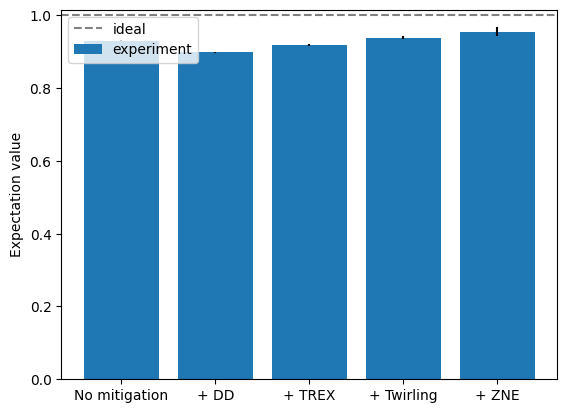

In [10]:
# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array(
    [float(pub_result.data.evs) for pub_result in pub_results]
)
standard_errors = np.array(
    [float(pub_result.data.stds) for pub_result in pub_results]
)

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(
    range(len(labels)),
    expectation_vals,
    yerr=standard_errors,
    label="experiment",
)
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

At this small scale, it is difficult to see the effect of most of the error mitigation techniques, but zero-noise extrapolation does give a noticeable improvement. However, note that this improvement does not come for free, because the ZNE result also has a larger error bar.

## Scale the experiment up

When developing an experiment, it's useful to start with a small circuit to make visualizations and simulations easier. Now that you've developed and tested our workflow on a 10-qubit circuit, you can scale it up to 50 qubits. The following code cell repeats all of the steps in this tutorial, but now applies them to a 50-qubit circuit.

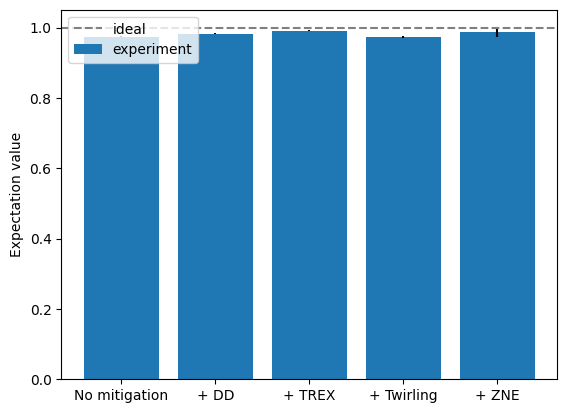

In [11]:
n_qubits = 50
reps = 1

# Construct circuit and observable
circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)
observable = SparsePauliOp.from_sparse_list(
    [("Z", [-1], 1.0)], num_qubits=n_qubits
)

# Assign parameters to circuit
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)
assigned_circuit = circuit.assign_parameters(params)
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

# Transpile circuit and observable
isa_circuit = pass_manager.run(mirror_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

# Run jobs
pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array(
    [float(pub_result.data.evs) for pub_result in pub_results]
)
standard_errors = np.array(
    [float(pub_result.data.stds) for pub_result in pub_results]
)

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(
    range(len(labels)),
    expectation_vals,
    yerr=standard_errors,
    label="experiment",
)
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

When you compare the 50-qubit results with the 10-qubit results from earlier, you might note the following (your results might differ across runs):

- The results without error mitigation are worse. Running the larger circuit involves executing more gates, so there are more opportunities for errors to accumulate.
- The addition of dynamical decoupling might have worsened performance. This is not surprising, because the circuit is very dense. Dynamical decoupling is primarily useful when there are large gaps in the circuit during which qubits sit idle without gates being applied to them. When these gaps are not present, dynamical decoupling is not effective, and can actually worsen performance due to errors in the dynamical decoupling pulses themselves. The 10-qubit circuit may have been too small for us to observe this effect.
- With zero-noise extrapolation, the result is as good, or nearly as good, as the 10-qubit result, though the error bar is much larger. This demonstrates the power of the ZNE technique!

## Conclusion

In this tutorial, you investigated different error mitigation options available for the Qiskit Runtime Estimator primitive. You developed a workflow using a 10-qubit circuit, and then scaled it up to 50 qubits. You might have observed that enabling more error suppression and mitigation options doesn't always improve performance (specifically, enabling dynamical decoupling in this case). Most of the options accept additional configuration, which you can test out in your own work!

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_cUCGeqAAI7suE3I)